In [25]:
from scipy.io import mmread, mmwrite
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import umap
from scipy import stats
import seaborn as sns
from matplotlib.lines import Line2D
import anndata as ad
import scanpy as sc
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import binarize

In [2]:
def myhist(ax, data, title=None, xlabel=None, ylabel=None):
    ax.hist(data, bins=50, edgecolor='w')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [41]:
def set_axis(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
def myumap2_plot(umap, group_series, annotate=False, size=0.5, title=None, ignore_list = []):
    ## group:color dict
    try:
        group = group_series.unique().sort_values()
    except:
        group = group_series.unique()
    color = sns.color_palette('hsv',n_colors=len(group))
    #shuffle(color)
    color_dict = {group[x]:color[x] for x in range(len(group))}
    c=[color_dict[x] for x in group_series]
    ## Artist of the figure legend
    elements = [Line2D([0], [0], marker='o', color='w',
                        markerfacecolor=x, markersize=15) for x in color_dict.values()]

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(umap[:,0],umap[:,1],c=c,s=size)
    ax.set_title(title)
    set_axis(ax)
    
    ## annotate cell types on the UMAP plot
    if annotate:
        ## find the position of the first matched cell type
        for cell in group:
            if (group_series.value_counts()[cell] > 100) and (cell not in ignore_list):
                ct_id = np.where(group_series == cell)[0]
                ax.annotate(cell, (np.mean(umap[ct_id,0]), np.mean(umap[ct_id,1])),
                           bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'),
                           fontsize=8)
                  
    fig.legend(elements, color_dict.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4)
    plt.show()

In [4]:
def set_axis(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
def group_umap2_plot(umap1,umap2,umap3, group_series, data=None, annotate=False, size=0.5):
    ## group:color dict
    group = group_series.unique()
    color = sns.color_palette('hsv',n_colors=len(group))
    #shuffle(color)
    color_dict = {group[x]:color[x] for x in range(len(group))}
    c=[color_dict[x] for x in group_series]
    ## Artist of the figure legend
    elements = [Line2D([0], [0], marker='o', color='w',
                        markerfacecolor=x, markersize=15) for x in color_dict.values()]

    fig, axs = plt.subplots(1,3,figsize=(12,4))
    axs[0].scatter(umap1[:,0],umap1[:,1],c=c,s=size)
    axs[0].set_title('RNA')
    set_axis(axs[0])
    axs[1].scatter(umap2[:,0],umap2[:,1],c=c,s=size)
    axs[1].set_title('ATAC')
    set_axis(axs[1])
    axs[2].scatter(umap3[:,0],umap3[:,1],c=c,s=size)
    axs[2].set_title('WNN')
    set_axis(axs[2])
    
    if annotate:
        ## find the position of the first matched cell type
        for cell in group:
            if group_series.value_counts()[cell] > 100:
                ct_id = np.where(group_series == cell)[0]
                axs[0].annotate(cell, (np.mean(umap1[ct_id,0]), np.mean(umap1[ct_id,1])))
                axs[1].annotate(cell, (np.mean(umap2[ct_id,0]), np.mean(umap2[ct_id,1])))
                axs[2].annotate(cell, (np.mean(umap3[ct_id,0]), np.mean(umap3[ct_id,1])))
                  
    fig.legend(elements, color_dict.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
    plt.show()

# Granja et al. scATAC-seq

In [ ]:
# run Granja-save_SumExp.r first
# save Anndata object
counts = mmread("../raw/scATAC-Healthy-Hematopoiesis-191120-counts.mtx").tocsr().transpose()
obs_meta = pd.read_csv("../raw/scATAC-Healthy-Hematopoiesis-191120-cols.csv", index_col=0)
vars_meta = pd.read_csv("../raw/scATAC-Healthy-Hematopoiesis-191120-rows.csv", index_col=0)

adata = ad.AnnData(counts, obs=obs_meta, var=vars_meta)

# binarize ATAC count matrix
def binarize(x):
    x1=x.copy()
    x1[x1 != 0]=1
    return x1

b_counts = binarize(adata.X)

adata.layers['b'] = b_counts

adata.write("../raw/scATAC-Healthy-Hematopoiesis-191120-adata")

## QC plots

In [5]:
adata = ad.read_h5ad("../raw/scATAC-Healthy-Hematopoiesis-191120-adata")

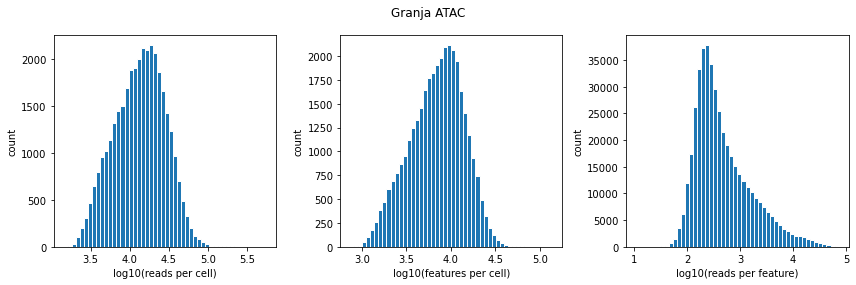

In [6]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

# reads per cell (column sum or peak depth)
myhist(ax[0],
       np.log10(adata.X.sum(axis=1).tolist()),
      xlabel = 'log10(reads per cell)',
      ylabel = 'count')

# features per cell
myhist(ax[1],
      np.log10(adata.layers['b'].sum(axis=1).tolist()),
      xlabel = 'log10(features per cell)',
      ylabel = 'count')

# reads per feature (row sum)
myhist(ax[2],
      np.log10(adata.X.sum(axis=0).tolist()[0]),
      xlabel = 'log10(reads per feature)',
      ylabel = 'count')

fig.suptitle('Granja ATAC')
fig.tight_layout()
#fig.savefig('../figures/qc/Granja_atac.png')
plt.show()

## Dimensionality reduction

In [7]:
# TFIDF
transformer = TfidfTransformer(smooth_idf=True)
tfidf_m = transformer.fit_transform(adata.layers['b'])

svd = TruncatedSVD(n_components=50)
LSI_m = svd.fit_transform(tfidf_m)

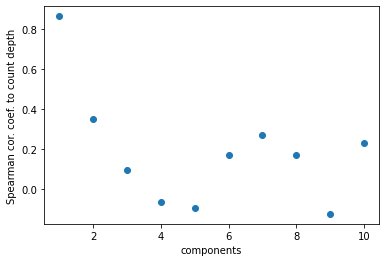

In [8]:
# Spearman correlation between top 10 dimensions and count depth
x=adata.X.sum(axis=1).tolist()

r_list = []
for i in range(10):
    r,p=stats.spearmanr(LSI_m[:,i],x)
    r_list.append(r)

plt.scatter(np.arange(1,11),r_list)
plt.ylabel('Spearman cor. coef. to count depth')
plt.xlabel('components')
plt.show()

The first dimension in LSI is highly correlated to count depth and, thus, not included for UMAP dimensionality reduction.

In [9]:
# UMAP embedding
reducer = umap.UMAP(n_neighbors=55, min_dist=0.45,random_state=35)
umap2 = reducer.fit_transform(LSI_m[:,1:50])

In [ ]:
# save the 2D UMAP
np.savetxt('../processed/Granja_ATAC_umap2.csv', umap2, delimiter=',')

In [10]:
# read the 2D UMAP
umap2 = np.genfromtxt('../processed/Granja_ATAC_umap2.csv', delimiter=',')

## Visualization

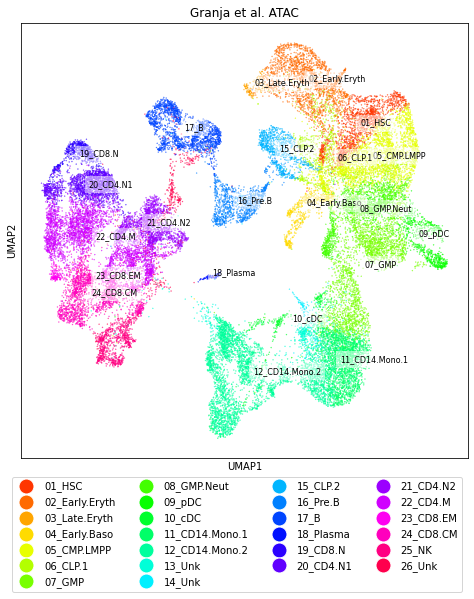

In [11]:
myumap2_plot(umap2, adata.obs['BioClassification'], annotate=True, size=0.1, title='Granja et al. ATAC', ignore_list = ['25_NK','26_Unk','14_Unk','13_Unk'])

# Luecken et al. multiome BMMC

## QC plots

In [12]:
adata = ad.read_h5ad('../raw/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

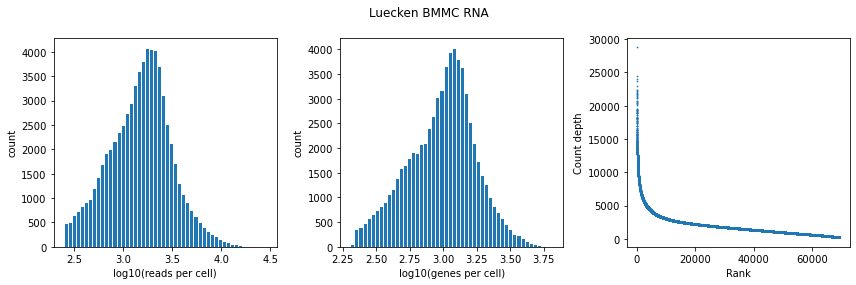

In [13]:
# GEX
fig, ax = plt.subplots(1,3,figsize=(12,4))

# reads per cell (count depth)
myhist(ax[0],
      np.log10(adata.obs['GEX_n_counts']),
      xlabel = 'log10(reads per cell)',
      ylabel = 'count')

# genes per cell
myhist(ax[1],
      np.log10(adata.obs['GEX_n_genes']),
      xlabel = 'log10(genes per cell)',
      ylabel = 'count')

# rank count depth
ax[2].scatter(adata.obs['GEX_n_counts'].rank(ascending=False), adata.obs['GEX_n_counts'],s=0.5)
#ax[2].set_title('Ranked count depth')
ax[2].set_xlabel('Rank')
ax[2].set_ylabel('Count depth')

fig.suptitle('Luecken BMMC RNA')
fig.tight_layout()
#fig.savefig('../figures/qc/Luecken_rna.png')
plt.show()

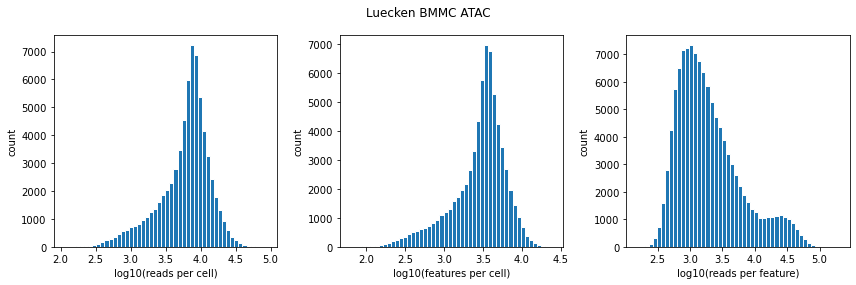

In [14]:
# ATAC
iATAC = np.where(adata.var['feature_types']=='ATAC')[0]
fig, ax = plt.subplots(1,3,figsize=(12,4))

# reads per cell (column sum or peak depth)
myhist(ax[0],
       np.log10(adata.obs['ATAC_nCount_peaks']),
       xlabel = 'log10(reads per cell)',
      ylabel = 'count')

# features per cell
myhist(ax[1],
      np.log10(adata.X[:,iATAC].sum(axis=1).tolist()),
      xlabel = 'log10(features per cell)',
      ylabel = 'count')

# reads per feature (row sum)
myhist(ax[2],
      np.log10(adata.layers['counts'][:,iATAC].sum(axis=0).tolist()[0]),
      xlabel = 'log10(reads per feature)',
      ylabel = 'count')

fig.suptitle('Luecken BMMC ATAC')
fig.tight_layout()
#fig.savefig('../figures/qc/Luecken_atac.png')
plt.show()

## Dimensionality reduction

In [15]:
iATAC = np.where(adata.var['feature_types']=='ATAC')[0]
iGEX = np.where(adata.var['feature_types']=='GEX')[0]

# ATAC dimensionality reduction
atac_adata = adata[:,iATAC]

# LSI
transformer = TfidfTransformer(smooth_idf=True)
tfidf_m = transformer.fit_transform(atac_adata.X)

svd = TruncatedSVD(n_components=50)
LSI_m = svd.fit_transform(tfidf_m)

reducer = umap.UMAP(n_neighbors=55, min_dist=0.45,random_state=35)
umap2 = reducer.fit_transform(LSI_m[:,1:50])

adata.obsm['ATAC_umap2']=umap2

In [16]:
# GEX dimensionality reduction
gex_adata = adata[:,iGEX]

# log(x+1) transform
sc.pp.log1p(gex_adata)
adata.obsm['GEX_lognorm'] = gex_adata.X

# identify highly variable genes
sc.pp.highly_variable_genes(gex_adata)

# PCA
sc.tl.pca(gex_adata,  n_comps=50)
adata.obsm['GEX_pca'] = gex_adata.obsm['X_pca']

reducer = umap.UMAP(n_neighbors=55, min_dist=0.45,random_state=35)
umap2 = reducer.fit_transform(adata.obsm['GEX_pca'])

adata.obsm['GEX_umap2']=umap2

/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Batch correction

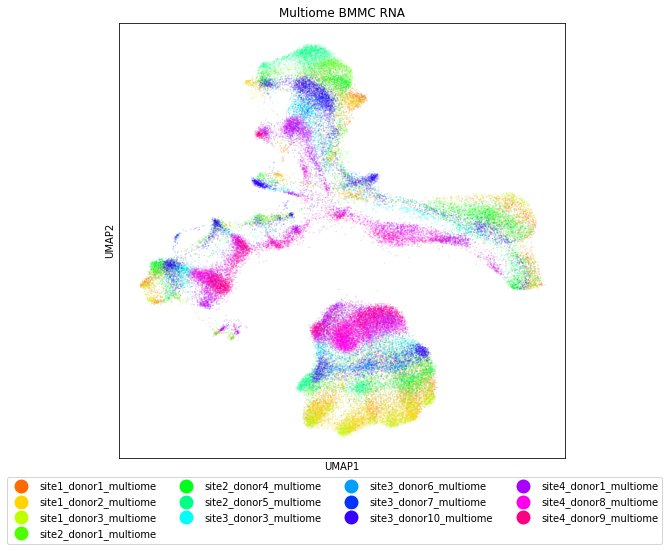

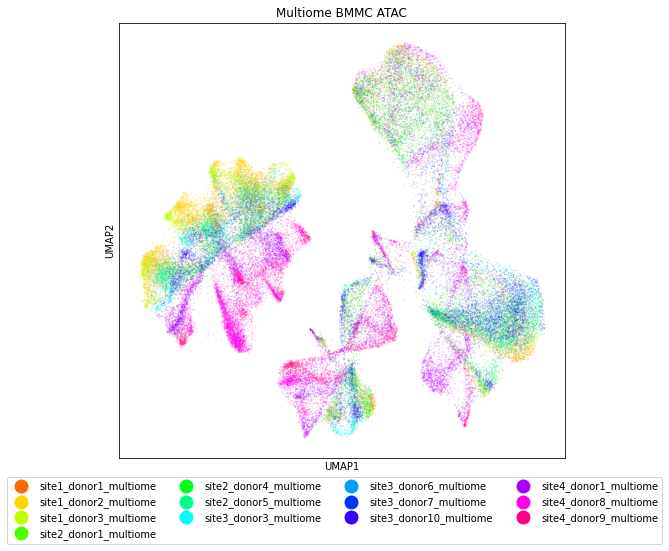

In [17]:
# visualization
myumap2_plot(adata.obsm['GEX_umap2'], adata.obs['Samplename'], size=0.01, title='Multiome BMMC RNA')
myumap2_plot(adata.obsm['ATAC_umap2'], adata.obs['Samplename'], size=0.01, title='Multiome BMMC ATAC')

Since the batch effect is present in the dataset, we applied Seurat (4.1.0) and Signac (1.6.0) to correct the batch effect. First, save all required data.

In [ ]:
# GEX
matrixr = adata.layers['counts'][:,iGEX].transpose()
mmwrite('../processed/Luecken_GEX_counts.mtx',matrixr)

adata.var.iloc[iGEX,:].to_csv('../processed/Luecken_GEX_var.tsv',sep='\t')
adata.obs.to_csv('../processed/Luecken_GEX_obs.tsv',sep='\t')

# ATAC
matrixr = adata.layers['counts'][:,iATAC].transpose()
mmwrite('../processed/Luecken_ATAC_counts.mtx',matrixr)

# genomic region
index=adata.var.loc[iATAC,:].index
bed=index.str.split('-', expand=True).to_frame(index=False, name=['chr','start','end'])
bed.to_csv('../processed/Luecken_ATAC.bed', sep='\t', header=None, index=None)

Run Luecken_multiome_integration.r before further analysis. 

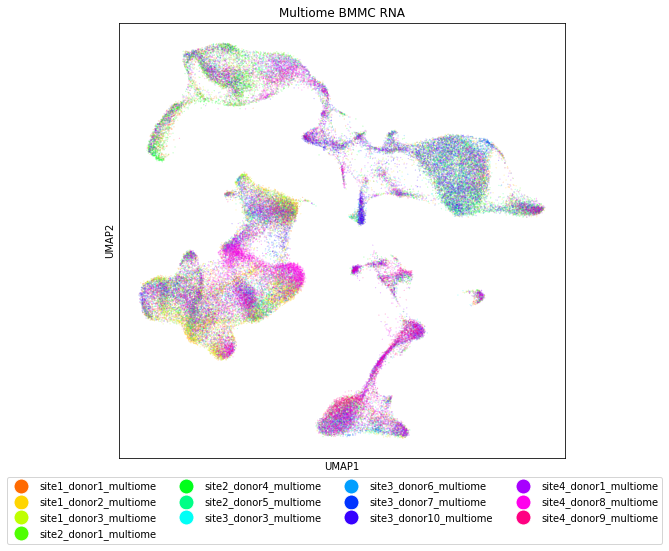

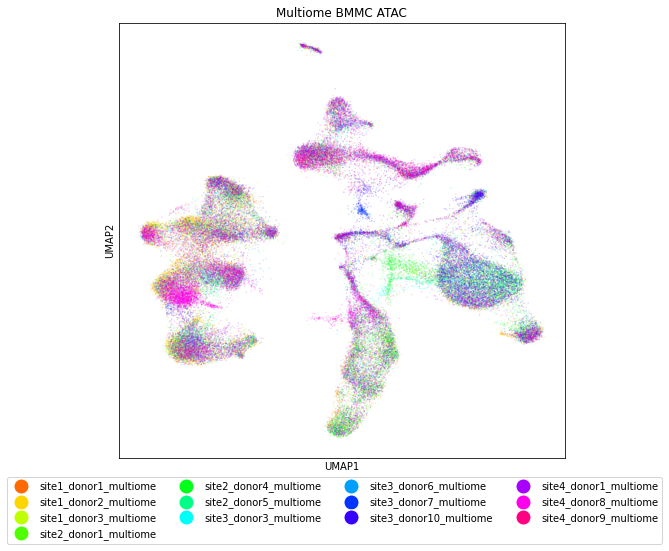

In [18]:
# visualization
GEX_umap2 = np.genfromtxt('../processed/Luecken_GEX_int_umap.csv', delimiter=',')
ATAC_umap2= np.genfromtxt('../processed/Luecken_ATAC_int_umap.csv', delimiter=',')

myumap2_plot(GEX_umap2, adata.obs['Samplename'], size=0.01, title='Multiome BMMC RNA')
myumap2_plot(ATAC_umap2, adata.obs['Samplename'], size=0.01, title='Multiome BMMC ATAC')

## Evaulation of the joint embedding
In Luecken_multiome_integration.r, we further integrate ATAC and RNA modalities into a joint Weighted Nearest Neighbor (WNN) embedding to facilitate downstream analysis. We calculated Davies-Bouldin scores based on 2D UMAP embeddings to show that WNN embedding better separates different cell types and aggregates the same cell type.

In [19]:
L_GEX_umap2 = np.genfromtxt('../processed/Luecken_GEX_int_umap.csv', delimiter=',')
L_ATAC_umap2= np.genfromtxt('../processed/Luecken_ATAC_int_umap.csv', delimiter=',')
L_wnn_umap2= np.genfromtxt('../processed/Luecken_wnn_umap.csv', delimiter=',')

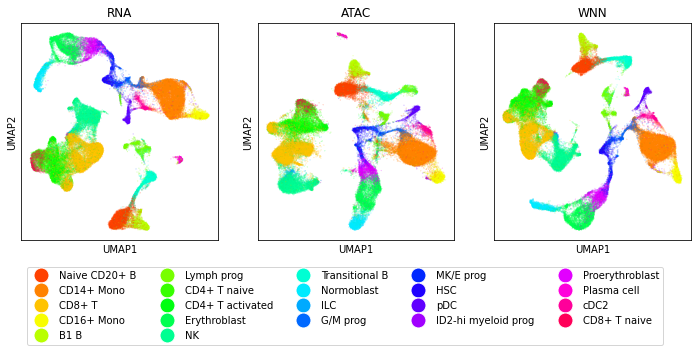

In [20]:
group_umap2_plot(L_GEX_umap2, L_ATAC_umap2, L_wnn_umap2, adata.obs['cell_type'], data='bmmc', annotate=False, size=0.01)

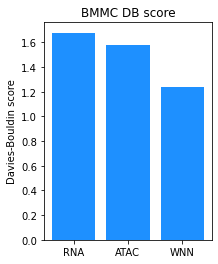

In [21]:
dbs_L_GEX = davies_bouldin_score(L_GEX_umap2, adata.obs['cell_type'])
dbs_L_ATAC = davies_bouldin_score(L_ATAC_umap2, adata.obs['cell_type'])
dbs_L_wnn = davies_bouldin_score(L_wnn_umap2, adata.obs['cell_type'])

plt.figure(figsize=(3,4))
plt.bar([0,1,2],[dbs_L_GEX, dbs_L_ATAC, dbs_L_wnn], color='dodgerblue')
plt.xticks(ticks=[0,1,2],labels=['RNA','ATAC','WNN'])
plt.ylabel('Davies-Bouldin score')
plt.title('BMMC DB score')
plt.show()

## Visualization

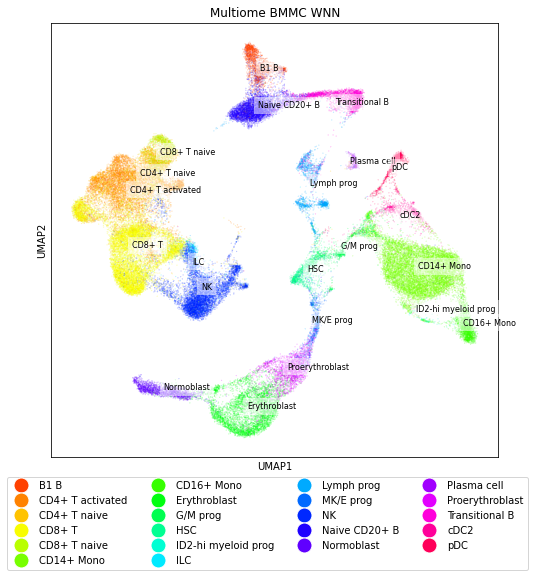

In [22]:
myumap2_plot(L_wnn_umap2, adata.obs['cell_type'], annotate=True, size=0.01, title='Multiome BMMC WNN')

# 10x Genomics multiome PBMC

The preprocessing and WNN integration was performed in R. Run 10X_multiome_preprocessing.r before further analysis.

## QC plots

In [23]:
adata_rna = sc.read_h5ad('../processed/10X_multiome/pbmc_rna.h5ad')
# normalize GEX
norm_rna = sc.pp.normalize_total(adata_rna, target_sum=1e6, copy=True)
sc.pp.log1p(norm_rna)
adata_rna.layers['lognorm_rna'] = norm_rna.X

In [26]:
adata_atac = sc.read_h5ad('../processed/10X_multiome/pbmc_atac.h5ad')

# binarize ATAC
adata_atac.layers['b_atac'] = binarize(adata_atac.X)

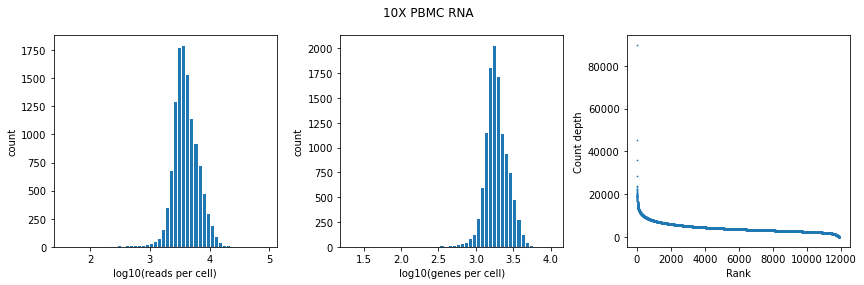

In [27]:
# GEX
fig, ax = plt.subplots(1,3,figsize=(12,4))

# reads per cell (count depth)
myhist(ax[0],
      np.log10(adata_rna.obs['nCount_RNA']),
      xlabel = 'log10(reads per cell)',
      ylabel = 'count')

# genes per cell
myhist(ax[1],
      np.log10(adata_rna.obs['nFeature_RNA']),
      xlabel = 'log10(genes per cell)',
      ylabel = 'count')

# rank count depth
ax[2].scatter(adata_rna.obs['nCount_RNA'].rank(ascending=False), adata_rna.obs['nCount_RNA'],s=0.5)
#ax[2].set_title('Ranked count depth')
ax[2].set_xlabel('Rank')
ax[2].set_ylabel('Count depth')

fig.suptitle('10X PBMC RNA')
fig.tight_layout()
plt.show()

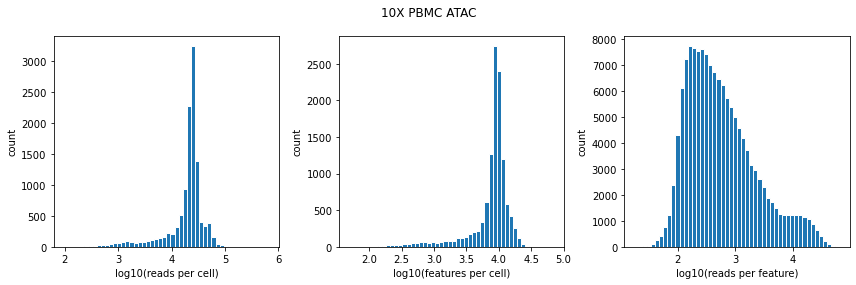

In [28]:
# ATAC
fig, ax = plt.subplots(1,3,figsize=(12,4))

# reads per cell (column sum or peak depth)
myhist(ax[0],
       np.log10(adata_atac.obs['nCount_ATAC']),
       xlabel = 'log10(reads per cell)',
      ylabel = 'count')

# features per cell
myhist(ax[1],
      np.log10(adata_atac.obs['nFeature_ATAC']),
      xlabel = 'log10(features per cell)',
      ylabel = 'count')

# reads per feature (row sum)
myhist(ax[2],
      np.log10(adata_atac.var['count']),
      xlabel = 'log10(reads per feature)',
      ylabel = 'count')

fig.suptitle('10X PBMC ATAC')
fig.tight_layout()
plt.show()

## Evaulation of the joint embedding

In [29]:
tenX_GEX_umap2 = np.genfromtxt('../processed/10X_multiome/RNA_umap.csv', delimiter=',')
tenX_ATAC_umap2= np.genfromtxt('../processed/10X_multiome/ATAC_umap.csv', delimiter=',')
tenX_wnn_umap2= np.genfromtxt('../processed/10X_multiome/wnn_umap.csv', delimiter=',')

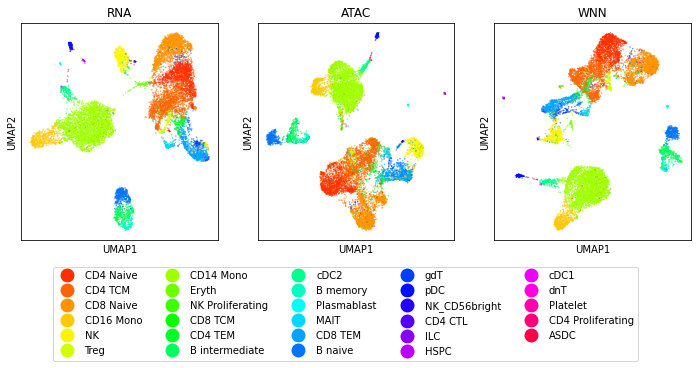

In [30]:
group_umap2_plot(tenX_GEX_umap2, tenX_ATAC_umap2, tenX_wnn_umap2, adata_atac.obs['predicted.id'], data='pbmc',annotate=False,size=0.1)

In [31]:
dbs_tx_GEX = davies_bouldin_score(tenX_GEX_umap2, adata_atac.obs['predicted.id'])
dbs_tx_ATAC = davies_bouldin_score(tenX_ATAC_umap2, adata_atac.obs['predicted.id'])
dbs_tx_wnn = davies_bouldin_score(tenX_wnn_umap2, adata_atac.obs['predicted.id'])

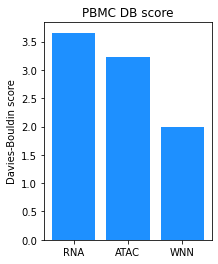

In [32]:
plt.figure(figsize=(3,4))
plt.bar([0,1,2],[dbs_tx_GEX, dbs_tx_ATAC, dbs_tx_wnn], color='dodgerblue')
plt.xticks(ticks=[0,1,2],labels=['RNA','ATAC','WNN'])
plt.ylabel('Davies-Bouldin score')
plt.title('PBMC DB score')
plt.show()

## Visualization

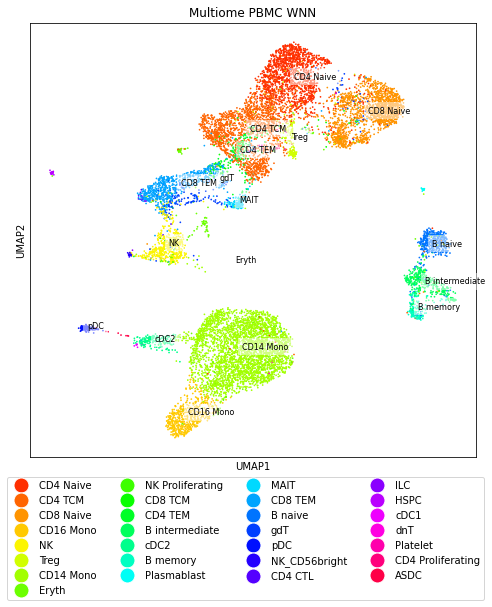

In [42]:
myumap2_plot(tenX_wnn_umap2, adata_atac.obs['predicted.id'], annotate=True, title='Multiome PBMC WNN')